In [1]:
#Feature matching is like template matching but here a replica from the image is not needed, we can use an image
#to extract key features and details from , and uisng a dist metric we can search for similar features in a secondary img

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def display(img, cmap = 'gray'):
    fig = plt.figure(figsize = (12, 10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap = 'gray')

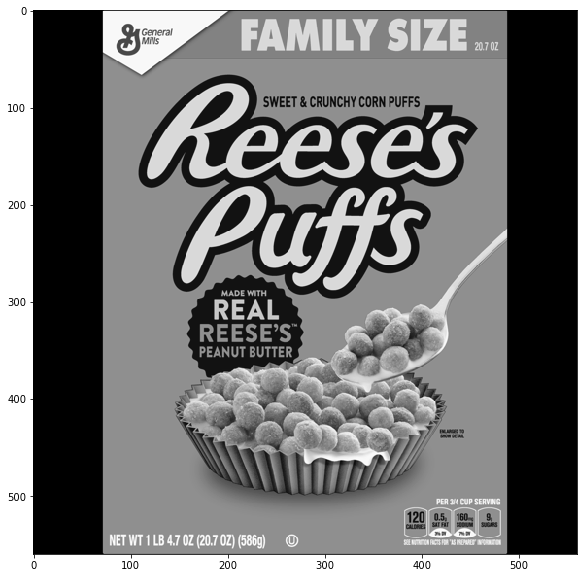

In [3]:
reeses = cv2.imread('../DATA/reeses_puffs.png', 0)
display(reeses)

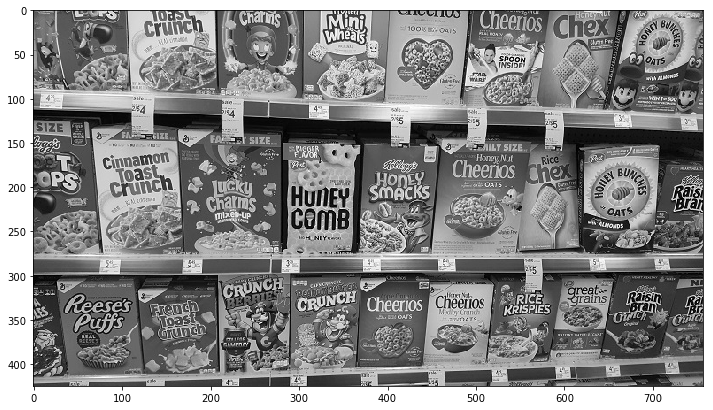

In [4]:
#the above is the target image (template to search for)
#the search image is the following

cereals = cv2.imread('../DATA/many_cereals.jpg', 0)
display(cereals)

In [5]:
#ORB detector - Oriented Fast and Rotated BRIEF -- combn of fast detector and BRIEF descriptor

#BRUTE FORCE SEARCH (DETECTION)

#initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(reeses, None)
kp2, des2 = orb.detectAndCompute(cereals, None)


In [6]:
len(kp1)

500

In [7]:
#BF matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

#match the descriptors
matches = bf.match(des1, des2)

In [8]:
len(matches)

263

In [9]:
type(matches)

list

In [10]:
single_match = matches[0]
single_match

<DMatch 0x7fe37c33f370>

In [11]:
#has an attr called dist, smaller the dist, closer the match, hence arrange in ASC and take first 25

matches = sorted(matches, key = lambda x:x.distance)

reeses_matches = cv2.drawMatches(reeses, kp1, cereals, kp2, matches, None, flags = 2) 
#flags of 2 is for lines
#flags of 0 is for lines and pts


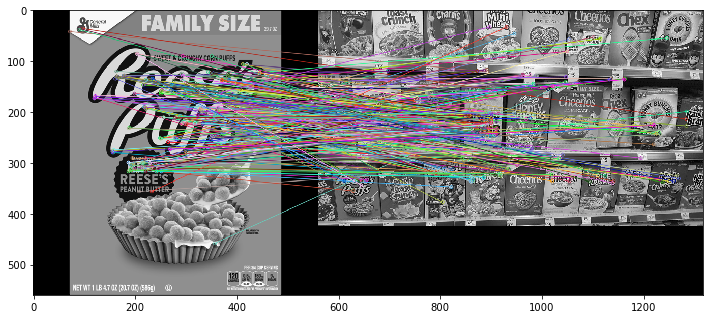

In [12]:
# matches
display(reeses_matches)

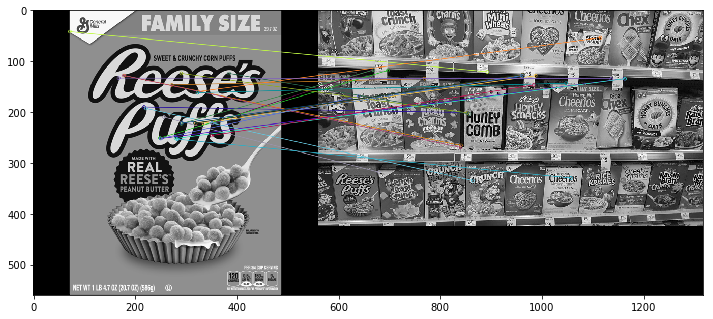

In [13]:
#limit the op to 25 top matches

#has an attr called dist, smaller the dist, closer the match, hence arrange in ASC and take first 25

matches = sorted(matches, key = lambda x:x.distance)

reeses_matches = cv2.drawMatches(reeses, kp1, cereals, kp2, matches[:25], None, flags = 2) 
#flags of 2 is for lines
#flags of 0 is for lines and pts

display(reeses_matches)

#inaccurate as it is matching FamSize and not the Reesepuffs

In [15]:
#SIFT DETECTORS AND RATIO TEST - BRUTE FORCE APPROACH
#scale invariant Feature transform - can detect any size at op, more accurate

sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(reeses, None)
kp2, des2 = sift.detectAndCompute(cereals, None)

bf = cv2.BFMatcher()

#here we use k top feature matches to be returned

matches = bf.knnMatch(des1, des2, k = 2) #2 matches are returned within each descriptor ( not exactly matches )

matches[0]

[<DMatch 0x7fe37b860ef0>, <DMatch 0x7fe37b918910>]

In [16]:
#each descriptor is a pair of feature distances - we need the ratio of these 2 two be less than a threshold
#meaning that we need to find one significant feature and the first one has a small dist as it is a match
#second one is relatively larger for the RATIO to be satisfied - it is like a noise, and hence the first one picked is the stand out feature

#GOTO : each keypoint of the first image is matched with a number of keypoints from the second image. We keep the 2 best matches for each keypoint
#(best matches = the ones with the smallest distance measurement). Lowe's test checks that the two distances are sufficiently different. 
#If they are not, then the keypoint is eliminated and will not be used for further calculations.

#save all the good features to plot

good = []

for match1, match2 in matches:
    if match1.distance < 0.75 * match2.distance:
        good.append([match1])
        
sift_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good, None, flags = 2)        

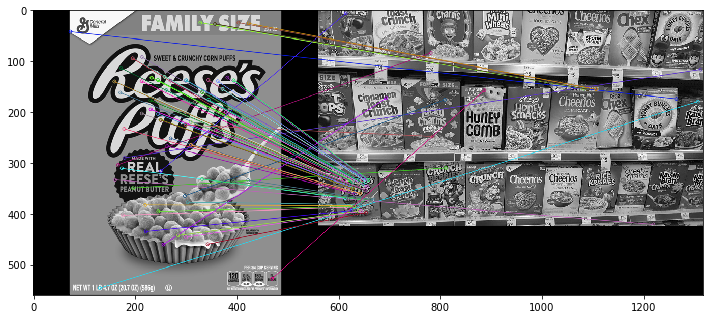

In [18]:
display(sift_matches)  #accurate

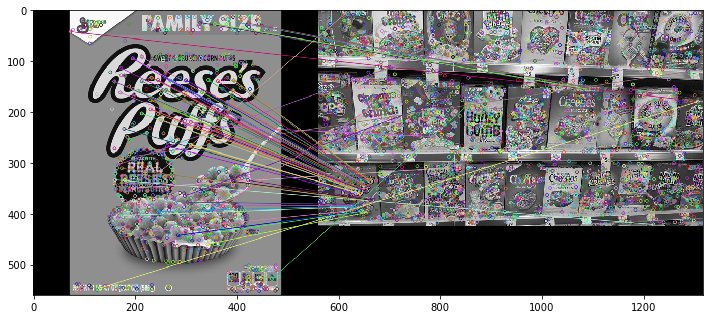

In [21]:
#FLANN based matcher

#this is Fast library for approx nearest nhbr
#accuracy is less but fast on complex searches
#uses a dict type param structure and not a brute force


sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(reeses, None)
kp2, des2 = sift.detectAndCompute(cereals, None) #none is for mask

#FLANN params
FLANN_INDEX_KD_TREE = 0
index_params = dict(algorithm = FLANN_INDEX_KD_TREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k = 2)

good = []

for match1, match2 in matches:
    if match1.distance < 0.75 * match2.distance:
        good.append([match1])
        
flann_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good, None, flags = 0)
display(flann_matches)
#flags 0 has drawins as well as lines
#there are single point color over the features found as well as the match which refers to the line

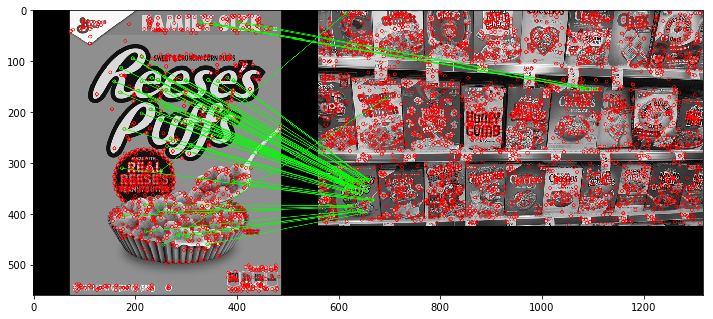

In [24]:
#Initiate SIFT detector
#MASKING to get all pts to one color and the lines to another color

sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(reeses, None)
kp2, des2 = sift.detectAndCompute(cereals, None) #none is for mask

#FLANN params
FLANN_INDEX_KD_TREE = 0
index_params = dict(algorithm = FLANN_INDEX_KD_TREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k = 2)

#we need to record the good matches
#make a mask for the matches
matches_mask = [[0, 0] for i in range(len(matches))]

for i, (match1, match2) in enumerate(matches):
    if match1.distance < 0.7 * match2.distance:
        matches_mask[i] = [1, 0]
        
draw_params = dict(matchColor = (0, 255, 0),
                  singlePointColor = (255, 0, 0),
                  matchesMask = matches_mask,
                  flags = 0)        
       
        
flann_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, matches, None, **draw_params)
display(flann_matches)
#flags 0 has drawings as well as lines
#there are single point color over the features found as well as the match which refers to the line